In [1]:
import sys
sys.path.append('../')

from model_runner import ModelRunner
from DBPN_copied import DBPN
from custom_image_dataset import CustomImageDataset
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch
torch.cuda.empty_cache()
from torch import nn
from image_helper import ImageHelper
import image_patches
import os
import pandas as pd
from GaussianNoise import AddGaussianNoise

In [2]:
# DATASET_ROOT="../datasets/"
TRAIN_DATASET_NAME = "../datasets/TRAIN_Flick2k_DIV2K/"
VALIDATION_DATASET_NAME = "../datasets/VALIDATION_Flickr2K_DIV2K/"

In [3]:
PATCH_SIZE = 128 # 32 * 4
# PATCHES_PER_IMAGE_TRAIN = 20
PATCHES_PER_IMAGE_TRAIN = 30 ##
# PATCHES_PER_IMAGE_TRAIN = 50 ##
# PATCHES_PER_IMAGE_TRAIN = 4
# PATCHES_PER_IMAGE_VALIDATION = 4
PATCHES_PER_IMAGE_VALIDATION = 20 ##
# PATCHES_PER_IMAGE_VALIDATION = 1
# PATCHES_PER_IMAGE_TRAIN = 45
# PATCHES_PER_IMAGE_VALIDATION = 12 # 45 // 4

In [4]:
TRAIN_DATA_PATH = f"{TRAIN_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_TRAIN}"
VALIDATION_DATA_PATH =  f"{VALIDATION_DATASET_NAME}_{PATCH_SIZE}_{PATCH_SIZE}_number={PATCHES_PER_IMAGE_VALIDATION}"
print('TRAIN_DATA_PATH =', TRAIN_DATA_PATH)
print('VALIDATION_DATA_PATH =', VALIDATION_DATA_PATH)

TRAIN_DATA_PATH = ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
VALIDATION_DATA_PATH = ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


In [5]:
# image_patches.create_valid_image_patches(f"{TRAIN_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), TRAIN_DATA_PATH, PATCHES_PER_IMAGE_TRAIN)
# image_patches.create_valid_image_patches(f"{VALIDATION_DATASET_NAME}", (PATCH_SIZE, PATCH_SIZE, 3), VALIDATION_DATA_PATH, PATCHES_PER_IMAGE_VALIDATION)

In [6]:
%%time

SCALE_FACTOR=4

transform_x = transforms.Compose([
    transforms.Resize((PATCH_SIZE // SCALE_FACTOR, PATCH_SIZE // SCALE_FACTOR), interpolation=Image.BICUBIC),
    # AddGaussianNoise(0., 0.1),
])

transform_y = transforms.Compose([
    transforms.CenterCrop((PATCH_SIZE, PATCH_SIZE))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=TRAIN_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)
validation_data_set = CustomImageDataset(
    img_dir=VALIDATION_DATA_PATH, transform=transform_x, target_transform=transform_y, tensor_size=PATCH_SIZE)

# Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30


100%|██████████| 2920/2920 [01:11<00:00, 40.86it/s]


Creating Dataset based on folder: ../datasets/TRAIN_Flick2k_DIV2K/_128_128_number=30
Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20


100%|██████████| 630/630 [00:10<00:00, 61.56it/s]


Creating Dataset based on folder: ../datasets/VALIDATION_Flickr2K_DIV2K/_128_128_number=20
Training set has 87539 instances
Validation set has 12592 instances
CPU times: user 1h 5min 12s, sys: 12.9 s, total: 1h 5min 25s
Wall time: 1min 28s


In [7]:
# image_helper = ImageHelper()
# image =  Image.open('../datasets/Set5/baby.png')
# image_tensor = image_helper.image_to_tensor(image)
# image_tensor = image_tensor + torch.randn(image_tensor.shape)*0.1
# image_helper.show_tensor_as_image(image_tensor)

In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = False
batch_size = round(1*(2**6))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory)
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: user 1.2 s, sys: 376 ms, total: 1.57 s
Wall time: 1.57 s


In [9]:
# image_helper = ImageHelper()
# i = 0
# for x, y in train_dataloader:
#     i += 1
#     if i > 2:
#         break
#     image_helper.show_tensor_as_image(x[0])
#     image_helper.show_tensor_as_image(y[0])
#     print(x.shape)
#     print(y.shape)
#     break

In [10]:
# The learning rate is initialized to 1e − 4 for all layers and decrease by a factor of 10 for every 5 × 105 iterations for total 106 iterations.
lr = 1e-3
model_betas = (0.9, 0.999)
device = torch.device('cuda:0')

# Total number of epochs
epochs = 25

model = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_runner = ModelRunner()

# For optimization, we use Adam with momentum to 0.9 and weight decay to 1e−4.
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=model_betas, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                              T_max = epochs, # Maximum number of iterations.
                             eta_min = 1e-6) # Minimum learning rate.

In [11]:
%%time
model_runner.train(
    model=model,
    train_dataloader=train_dataloader,
    validation_dataloader=validation_dataloader,
    optimizer=optimizer,
    epochs=epochs,
    scheduler=scheduler,
    loss_fn=nn.MSELoss(),
    save_file_path='./DBPN-real-run-medium-dataset-no-noise-cuda-0.txt'
)


epoch 0
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


  0%|          | 0/1368 [00:00<?, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.045715 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004887 

Learning rate (antes): 0.001
Learning rate (depois): 0.0009960612933065818
Epoch: 0
Time: 454.11458253860474
Learning rate: 0.0009960612933065818
Train loss: 0.04571515601026221
Validation loss: 0.00488657414319873
Elapsed time: 454.1146512031555

epoch 1
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004950 



100%|██████████| 197/197 [00:23<00:00,  8.40it/s]


Validation Error: 
 Avg loss: 0.004462 

Learning rate (antes): 0.0009960612933065818
Learning rate (depois): 0.0009843072889837514
Epoch: 1
Time: 453.9608302116394
Learning rate: 0.0009843072889837514
Train loss: 0.004950343961051355
Validation loss: 0.004462387448833868
Elapsed time: 453.96089577674866

epoch 2
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:08<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004561 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004423 

Learning rate (antes): 0.0009843072889837514
Learning rate (depois): 0.000964923354701182
Epoch: 2
Time: 454.05710077285767
Learning rate: 0.000964923354701182
Train loss: 0.004560647539492173
Validation loss: 0.0044234367837978125
Elapsed time: 454.05716586112976

epoch 3
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004510 



100%|██████████| 197/197 [00:23<00:00,  8.39it/s]


Validation Error: 
 Avg loss: 0.004361 

Learning rate (antes): 0.000964923354701182
Learning rate (depois): 0.0009382151866819102
Epoch: 3
Time: 453.87630462646484
Learning rate: 0.0009382151866819102
Train loss: 0.004509838900803888
Validation loss: 0.004360764061081871
Elapsed time: 453.876371383667

epoch 4
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004475 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 0.004298 

Learning rate (antes): 0.0009382151866819102
Learning rate (depois): 0.0009046039886902867
Epoch: 4
Time: 453.5998556613922
Learning rate: 0.0009046039886902867
Train loss: 0.004475493061836885
Validation loss: 0.0042978777933681414
Elapsed time: 453.5999231338501

epoch 5
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004471 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 0.004300 

Learning rate (antes): 0.0009046039886902867
Learning rate (depois): 0.0008646198293969955
Epoch: 5
Time: 453.36350417137146
Learning rate: 0.0008646198293969955
Train loss: 0.0044711524631204464
Validation loss: 0.0043002362983528206
Elapsed time: 453.36358308792114

epoch 6
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:07<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004474 



100%|██████████| 197/197 [00:23<00:00,  8.42it/s]


Validation Error: 
 Avg loss: 0.004473 

Learning rate (antes): 0.0008646198293969955
Learning rate (depois): 0.0008188932828794708
Epoch: 6
Time: 453.0811722278595
Learning rate: 0.0008188932828794708
Train loss: 0.004474060692993259
Validation loss: 0.004472760531193279
Elapsed time: 453.0812385082245

epoch 7
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:06<00:00,  3.20it/s]


Training Error: 
 Avg loss: 0.004493 



100%|██████████| 197/197 [00:23<00:00,  8.43it/s]


Validation Error: 
 Avg loss: 0.004494 

Learning rate (antes): 0.0008188932828794708
Learning rate (depois): 0.000768145484092009
Epoch: 7
Time: 452.860098361969
Learning rate: 0.000768145484092009
Train loss: 0.004493280478320166
Validation loss: 0.004493505071711533
Elapsed time: 452.8601653575897

epoch 8
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:06<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004508 



100%|██████████| 197/197 [00:23<00:00,  8.44it/s]


Validation Error: 
 Avg loss: 0.004347 

Learning rate (antes): 0.000768145484092009
Learning rate (depois): 0.0007131767561367541
Epoch: 8
Time: 452.2431540489197
Learning rate: 0.0007131767561367541
Train loss: 0.00450846615141225
Validation loss: 0.004346858681980898
Elapsed time: 452.24322271347046

epoch 9
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:06<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004508 



100%|██████████| 197/197 [00:23<00:00,  8.47it/s]


Validation Error: 
 Avg loss: 0.004360 

Learning rate (antes): 0.0007131767561367541
Learning rate (depois): 0.0006548539886902865
Epoch: 9
Time: 451.8364808559418
Learning rate: 0.0006548539886902865
Train loss: 0.004508202148694
Validation loss: 0.004359751900180531
Elapsed time: 451.8365476131439

epoch 10
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:05<00:00,  3.21it/s]


Training Error: 
 Avg loss: 0.004500 



100%|██████████| 197/197 [00:23<00:00,  8.48it/s]


Validation Error: 
 Avg loss: 0.004340 

Learning rate (antes): 0.0006548539886902865
Learning rate (depois): 0.0005940969666355698
Epoch: 10
Time: 451.3519067764282
Learning rate: 0.0005940969666355698
Train loss: 0.0045004420406906725
Validation loss: 0.004339510012065831
Elapsed time: 451.35197377204895

epoch 11
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:03<00:00,  3.23it/s]


Training Error: 
 Avg loss: 0.004494 



100%|██████████| 197/197 [00:23<00:00,  8.49it/s]


Validation Error: 
 Avg loss: 0.004363 

Learning rate (antes): 0.0005940969666355698
Learning rate (depois): 0.0005318638645048923
Epoch: 11
Time: 449.5803999900818
Learning rate: 0.0005318638645048923
Train loss: 0.004493962302606564
Validation loss: 0.004362605812340067
Elapsed time: 449.58050894737244

epoch 12
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [07:00<00:00,  3.25it/s]


Training Error: 
 Avg loss: 0.004483 



100%|██████████| 197/197 [00:23<00:00,  8.52it/s]


Validation Error: 
 Avg loss: 0.004322 

Learning rate (antes): 0.0005318638645048923
Learning rate (depois): 0.0004691361354951082
Epoch: 12
Time: 446.6688537597656
Learning rate: 0.0004691361354951082
Train loss: 0.004483433760810175
Validation loss: 0.004321867155104989
Elapsed time: 446.6689202785492

epoch 13
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:57<00:00,  3.27it/s]


Training Error: 
 Avg loss: 0.004475 



100%|██████████| 197/197 [00:23<00:00,  8.56it/s]


Validation Error: 
 Avg loss: 0.004327 

Learning rate (antes): 0.0004691361354951082
Learning rate (depois): 0.00040690303336443076
Epoch: 13
Time: 443.51391887664795
Learning rate: 0.00040690303336443076
Train loss: 0.004475329371001735
Validation loss: 0.004327230881143191
Elapsed time: 443.51398611068726

epoch 14
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:56<00:00,  3.28it/s]


Training Error: 
 Avg loss: 0.004469 



100%|██████████| 197/197 [00:22<00:00,  8.58it/s]


Validation Error: 
 Avg loss: 0.004324 

Learning rate (antes): 0.00040690303336443076
Learning rate (depois): 0.0003461460113097141
Epoch: 14
Time: 442.44874906539917
Learning rate: 0.0003461460113097141
Train loss: 0.004468882834941846
Validation loss: 0.004324048762871567
Elapsed time: 442.448814868927

epoch 15
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:55<00:00,  3.29it/s]


Training Error: 
 Avg loss: 0.004463 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004323 

Learning rate (antes): 0.0003461460113097141
Learning rate (depois): 0.00028782324386324637
Epoch: 15
Time: 441.3861634731293
Learning rate: 0.00028782324386324637
Train loss: 0.004463393695425101
Validation loss: 0.004323420120429172
Elapsed time: 441.38622999191284

epoch 16
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:55<00:00,  3.29it/s]


Training Error: 
 Avg loss: 0.004461 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004318 

Learning rate (antes): 0.00028782324386324637
Learning rate (depois): 0.00023285451590799116
Epoch: 16
Time: 440.6955289840698
Learning rate: 0.00023285451590799116
Train loss: 0.00446069053471584
Validation loss: 0.004317547134383756
Elapsed time: 440.6955964565277

epoch 17
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:55<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004456 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004316 

Learning rate (antes): 0.00023285451590799116
Learning rate (depois): 0.00018210671712052954
Epoch: 17
Time: 440.65138483047485
Learning rate: 0.00018210671712052954
Train loss: 0.004455682673669905
Validation loss: 0.004316457159590298
Elapsed time: 440.6514518260956

epoch 18
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004452 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004313 

Learning rate (antes): 0.00018210671712052954
Learning rate (depois): 0.0001363801706030051
Epoch: 18
Time: 440.4378340244293
Learning rate: 0.0001363801706030051
Train loss: 0.004451943426127464
Validation loss: 0.004312534404086507
Elapsed time: 440.4379024505615

epoch 19
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004449 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 0.0001363801706030051
Learning rate (depois): 9.639601130971386e-05
Epoch: 19
Time: 440.1904933452606
Learning rate: 9.639601130971386e-05
Train loss: 0.004449411489039507
Validation loss: 0.004305036586938605
Elapsed time: 440.19056034088135

epoch 20
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004448 



100%|██████████| 197/197 [00:22<00:00,  8.60it/s]


Validation Error: 
 Avg loss: 0.004304 

Learning rate (antes): 9.639601130971386e-05
Learning rate (depois): 6.278481331809018e-05
Epoch: 20
Time: 439.9780206680298
Learning rate: 6.278481331809018e-05
Train loss: 0.0044477779189484165
Validation loss: 0.004303824244572918
Elapsed time: 439.9780876636505

epoch 21
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:54<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004446 



100%|██████████| 197/197 [00:22<00:00,  8.60it/s]


Validation Error: 
 Avg loss: 0.004305 

Learning rate (antes): 6.278481331809018e-05
Learning rate (depois): 3.607664529881847e-05
Epoch: 21
Time: 439.87106919288635
Learning rate: 3.607664529881847e-05
Train loss: 0.0044460077875577
Validation loss: 0.004305409431826266
Elapsed time: 439.8711402416229

epoch 22
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:53<00:00,  3.30it/s]


Training Error: 
 Avg loss: 0.004445 



100%|██████████| 197/197 [00:22<00:00,  8.60it/s]


Validation Error: 
 Avg loss: 0.004303 

Learning rate (antes): 3.607664529881847e-05
Learning rate (depois): 1.669271101624884e-05
Epoch: 22
Time: 439.43106842041016
Learning rate: 1.669271101624884e-05
Train loss: 0.00444515719356244
Validation loss: 0.004302678974865354
Elapsed time: 439.4311454296112

epoch 23
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:53<00:00,  3.31it/s]


Training Error: 
 Avg loss: 0.004444 



100%|██████████| 197/197 [00:22<00:00,  8.59it/s]


Validation Error: 
 Avg loss: 0.004301 

Learning rate (antes): 1.669271101624884e-05
Learning rate (depois): 4.938706693418358e-06
Epoch: 23
Time: 439.0225033760071
Learning rate: 4.938706693418358e-06
Train loss: 0.004443792778929172
Validation loss: 0.004301403975941543
Elapsed time: 439.0225715637207

epoch 24
-------------------------------
Training on 87539 samples...
Batch size: 64
Number of batches: 1368


100%|██████████| 1368/1368 [06:53<00:00,  3.31it/s]


Training Error: 
 Avg loss: 0.004444 



100%|██████████| 197/197 [00:22<00:00,  8.60it/s]

Validation Error: 
 Avg loss: 0.004301 

Learning rate (antes): 4.938706693418358e-06
Learning rate (depois): 1e-06
Epoch: 24
Time: 438.64381670951843
Learning rate: 1e-06
Train loss: 0.004443541689291161
Validation loss: 0.004301142685592818
Elapsed time: 438.64388632774353
CPU times: user 3h 5min, sys: 1min 33s, total: 3h 6min 34s
Wall time: 3h 6min 6s


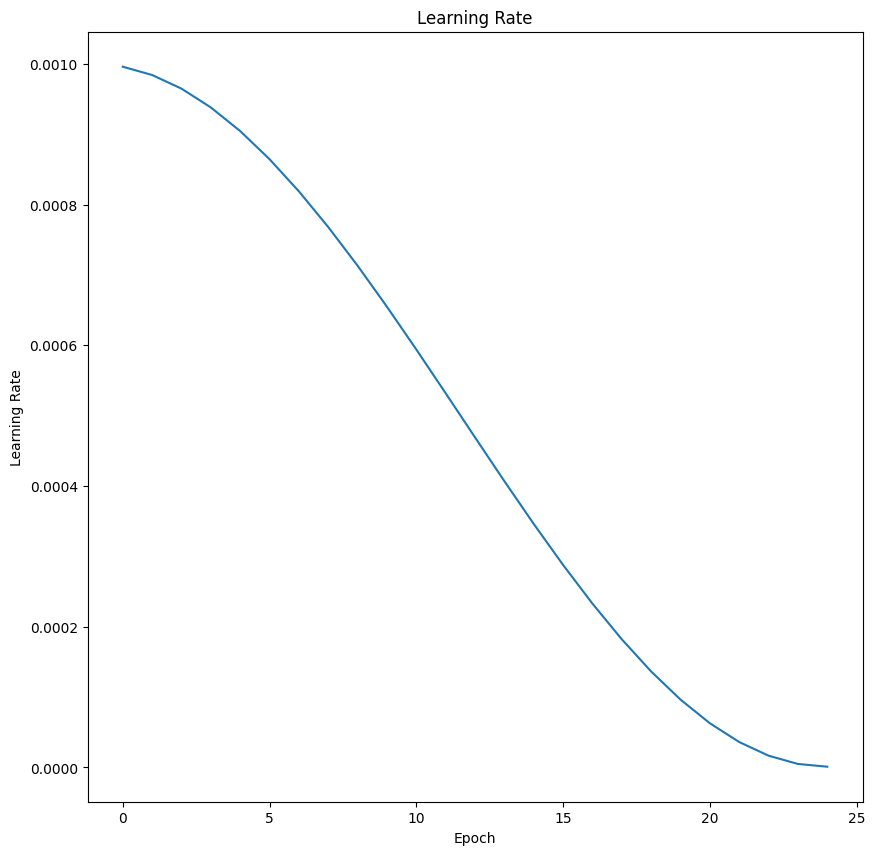

In [16]:
model_runner.plot_lr_from_df()

In [13]:
# model_runner.save_model_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-default-epoch=0-24.csv')
# model_runner.save_model_weights(model, '../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-default-epoch=0-24.pth')

In [32]:
df = model_runner.load_df('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-default-epoch=0-24.csv')
df

,epoch,time,lr,train_loss,validation_loss
0,0,454.114582,0.000996,0.045715,0.004887
1,1,453.960829,0.000984,0.004950,0.004462
2,2,454.057100,0.000965,0.004561,0.004423
3,3,453.876304,0.000938,0.004510,0.004361
4,4,453.599855,0.000905,0.004475,0.004298
5,5,453.363503,0.000865,0.004471,0.004300
6,6,453.081172,0.000819,0.004474,0.004473
7,7,452.860097,0.000768,0.004493,0.004494
8,8,452.243153,0.000713,0.004508,0.004347
9,9,451.836479,0.000655,0.004508,0.004360


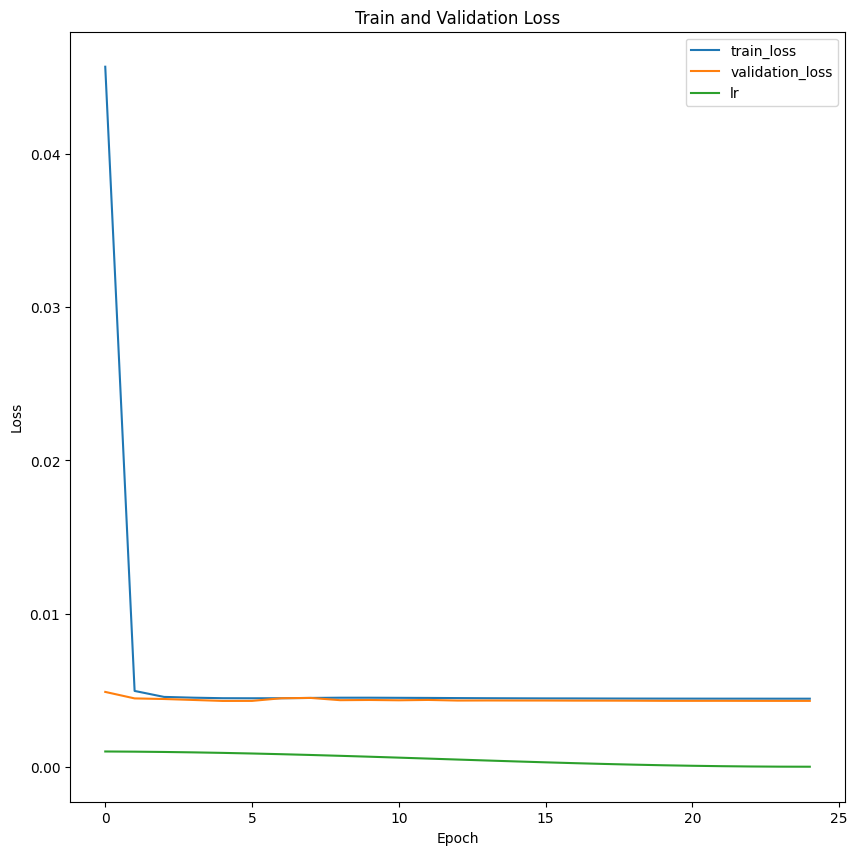

In [20]:
model_runner.plot_train_validation_loss_from_df(df)

/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


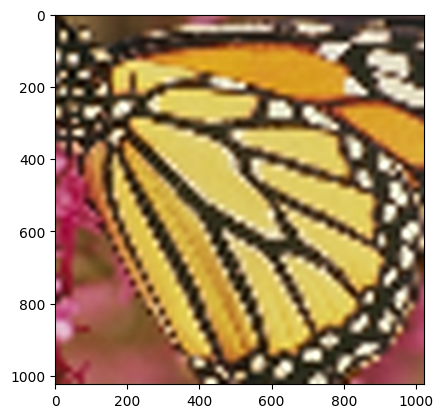

In [18]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)

In [22]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850729,0.652979
Bicubic,23.045410,0.632868


In [29]:
model_runner = ModelRunner(device=device)
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `P

,PSNR,SSIM
DBPN,24.850704,0.653421
Bicubic,23.045410,0.632868


In [29]:
model_2 = DBPN(num_channels=3, base_filter=64,  feat = 256, num_stages=7, scale_factor=4).to(device)
model_2.load_state_dict(torch.load('../results/dbpn/dataframes/DBPN-real-run-medium-dataset-lr-default-epoch=0-24.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [30]:
model_runner.compare_models(
    [
        {"name": "DBPN", "model": model_2,
                               "input_transform":lambda input: transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Resize(
                                    (input.size[1] // 4, input.size[0] // 4), interpolation=Image.BICUBIC),
                                ])(input),
                                "should_only_downsampple": True, "scale":4, "unsqueeze": True },
    ],
    f"../datasets/BSDS100/", scale=4
)

0it [00:00, ?it/s]/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:61: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
100it [00:03, 30.02it/s]
100it [00:01, 92.76it/s]


,PSNR,SSIM
DBPN,24.850729,0.652979
Bicubic,23.045410,0.632868


/home/pedrovelozo/TCC-Pedro-Velozo-ENG1132/env/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


should_upsample MUST ONLY BE `TRUE` for SRCNN


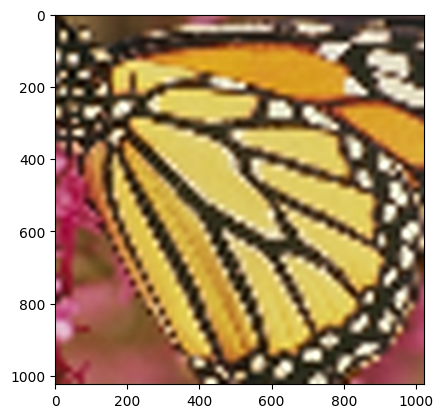

In [31]:
image_helper = ImageHelper()
image_helper.apply_model_to_image_and_show(
    model=model_2,
    image=f"../datasets/Set5/butterfly.png",
    downsample_factor=4,
    unsqueeze=True
)